In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#my function to check intersections and differences between sets of items
def check_sets(df1, col1, df2, col2, name1='first', name2='second'):
    set1 = set(df1[col1].unique())
    set2 = set(df2[col2].unique())
    print('in both files:', len(set1 & set2))
    print(f'in {name1} but not in {name2}:', len(set1 - set2))
    print(f'in {name2} but not in {name1}:', len(set2 - set1))

In [3]:
#read file
sales = pd.read_csv('sales_df_train.csv')
sales.head()

,st_id,pr_sku_id,date,pr_sales_type_id,pr_sales_in_units,pr_promo_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_rub
0,c81e728d9d4c2f636f067f89cc14862c,c7b711619071c92bef604c7ad68380dd,2022-10-20,1,5.0,5.0,825.0,825.0
1,42a0e188f5033bc65bf8d78622277c4e,68f441429e73dbd33b81f95da31576e9,2023-01-29,0,4.0,0.0,196.0,0.0
2,1ecfb463472ec9115b10c292ef8bc986,22988026fe85fde60d8bf777ab6bc3b4,2023-03-02,0,1.0,0.0,78.0,0.0
3,42a0e188f5033bc65bf8d78622277c4e,8e887cf8e64ab8e7173701a979476567,2023-04-05,1,0.0,0.0,69.0,69.0
4,16a5cdae362b8d27a1d8f8c7b78b4330,e6fc24ca846339d204b0b50e9f772484,2023-02-17,0,1.0,0.0,161.0,0.0


In [4]:
sales.shape

(883015, 8)

In [5]:
#drop 2 inactive stores
sales = sales[~sales['st_id'].isin(['1aa057313c28fa4a40c5bc084b11d276', '62f91ce9b820a491ee78c108636db089'])]
sales.shape

(882286, 8)

In [6]:
#estimate cases where sales in units are zero and in rubles not, or vice versa
zero_nonzero_sales = sales[((sales['pr_sales_in_units'] != 0) & (sales['pr_sales_in_rub'] == 0)) | ((sales['pr_sales_in_units'] == 0) & (sales['pr_sales_in_rub'] != 0))]
zero_nonzero_sales.shape

(66882, 8)

In [7]:
#drop cases where sales in units are zero and in rubles not, or vice versa
sales = sales[((sales['pr_sales_in_units'] != 0) & (sales['pr_sales_in_rub'] != 0)) | ((sales['pr_sales_in_units'] == 0) & (sales['pr_sales_in_rub'] == 0))]
sales.shape

(815404, 8)

In [8]:
#estimate negative sales
minus_sales = sales[(sales['pr_sales_in_rub'] < 0) | (sales['pr_sales_in_units'] < 0) | (sales['pr_promo_sales_in_rub'] < 0) |(sales['pr_promo_sales_in_units'] < 0)]
minus_sales.shape

(70, 8)

In [9]:
#drop negative sales
sales = sales[(sales['pr_sales_in_rub'] >= 0) & (sales['pr_sales_in_units'] >= 0) & (sales['pr_promo_sales_in_rub'] >= 0) & (sales['pr_promo_sales_in_units'] >= 0)]
sales.shape

(815334, 8)

In [10]:
#concat item-store pair into single unit
sales['store_item'] = sales['st_id'].str.cat(sales['pr_sku_id'], sep='-')
sales['store_item'].nunique()

6130

In [11]:
#glue together promo and non-promo sales of one item-store pair on same day
oneline = sales.groupby(['store_item', 'date'])[['pr_sales_in_units', 'pr_sales_in_rub', 'pr_promo_sales_in_units', 'pr_promo_sales_in_rub']].sum()
oneline.shape

(661192, 4)

In [12]:
#detect top50 item-store pairs
by_pair = oneline.groupby('store_item')[['pr_sales_in_units', 'pr_sales_in_rub']].agg(['sum', 'count'])
all_sales = by_pair[('pr_sales_in_rub', 'sum')].sum()
by_pair['all_sales_share'] = by_pair[('pr_sales_in_rub', 'sum')] / all_sales * 100
by_pair.sort_values([('pr_sales_in_units', 'sum')], ascending=False).head(50)

pr_sales_in_units        \
                                                                 sum count   
store_item                                                                   
16a5cdae362b8d27a1d8f8c7b78b4330-62d4af457ba254...           51500.0   352   
c81e728d9d4c2f636f067f89cc14862c-20d9b4bfd4b672...           42088.0   278   
42a0e188f5033bc65bf8d78622277c4e-ced0c1a84924c9...           34255.0   352   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-c0e3f3bd815a86...           32923.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-ced0c1a84924c9...           29678.0   352   
c81e728d9d4c2f636f067f89cc14862c-fd55c4022acef4...           27146.0   269   
42a0e188f5033bc65bf8d78622277c4e-c0e3f3bd815a86...           25856.0   352   
6364d3f0f495b6ab9dcf8d3b5c6e0b01-4b083e10f6cd2f...           25122.0   324   
16a5cdae362b8d27a1d8f8c7b78b4330-cf91eca9321c9c...           24716.0   352   
f7e6c85504ce6e82442c770f7c8606f0-4695acecbef473...           24555.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-c0e3f3bd815a86...           22423.0   352   
c81e728d9d4c2f636f067f89cc14862c-62d4af457ba254...           22350.0   350   
42a0e188f5033bc65bf8d78622277c4e-d5bfeecaaa4788...           21993.0   351   
f7e6c85504ce6e82442c770f7c8606f0-4b083e10f6cd2f...           21972.0   341   
42a0e188f5033bc65bf8d78622277c4e-1d2448c22721c9...           21750.0   351   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-d5bfeecaaa4788...           21380.0   352   
6364d3f0f495b6ab9dcf8d3b5c6e0b01-c0e3f3bd815a86...           20988.0   349   
c81e728d9d4c2f636f067f89cc14862c-0a2090e24b6ae6...           19296.0   333   
f7e6c85504ce6e82442c770f7c8606f0-62d4af457ba254...           19274.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-5aa2f6e00873f8...           16735.0   351   
42a0e188f5033bc65bf8d78622277c4e-cf91eca9321c9c...           16478.0   352   
f7e6c85504ce6e82442c770f7c8606f0-ced0c1a84924c9...           16083.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-ae9aebfac21c0f...           15836.0   335   
c81e728d9d4c2f636f067f89cc14862c-c0e3f3bd815a86...           15732.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-4e824a65fbd01f...           15717.0   352   
16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e92560...           15296.0   351   
6364d3f0f495b6ab9dcf8d3b5c6e0b01-5fb6bfa7b7d9a4...           14961.0   336   
6364d3f0f495b6ab9dcf8d3b5c6e0b01-ced0c1a84924c9...           14658.0   351   
42a0e188f5033bc65bf8d78622277c4e-62d4af457ba254...           13934.0   351   
f7e6c85504ce6e82442c770f7c8606f0-d5bfeecaaa4788...           13919.0   345   
16a5cdae362b8d27a1d8f8c7b78b4330-4b083e10f6cd2f...           13832.0   283   
c81e728d9d4c2f636f067f89cc14862c-6b1344097385a4...           13740.0   351   
6364d3f0f495b6ab9dcf8d3b5c6e0b01-71c9661741caf4...           13430.0   349   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-ced0c1a84924c9...           13419.0   352   
42a0e188f5033bc65bf8d78622277c4e-5fb6bfa7b7d9a4...           13398.0   339   
42a0e188f5033bc65bf8d78622277c4e-0a68dd43c227b0...           12835.0   330   
c81e728d9d4c2f636f067f89cc14862c-cf91eca9321c9c...           12390.0   352   
f7e6c85504ce6e82442c770f7c8606f0-5aa2f6e00873f8...           12268.0   350   
16a5cdae362b8d27a1d8f8c7b78b4330-6e456038d55730...           12008.0   313   
c81e728d9d4c2f636f067f89cc14862c-4b083e10f6cd2f...           11960.0   146   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-1d2448c22721c9...           11501.0   345   
f7e6c85504ce6e82442c770f7c8606f0-5fb6bfa7b7d9a4...           11019.0   295   
c81e728d9d4c2f636f067f89cc14862c-ced0c1a84924c9...           10972.0   352   
42a0e188f5033bc65bf8d78622277c4e-4a15a652bde1a9...           10819.0   305   
16a5cdae362b8d27a1d8f8c7b78b4330-67797f1f0f02ec...           10530.0   352   
c81e728d9d4c2f636f067f89cc14862c-c24c65259d90ed...           10433.0   352   
6364d3f0f495b6ab9dcf8d3b5c6e0b01-d5bfeecaaa4788...           10373.0   329   
fa7cdfad1a5aaf8370ebeda47a1ff1c3-4b083e10f6cd2f...           10219.0   275   
42a0e188f5033bc65bf8d78622277c4e-c4a665596d4f67...           10137.0   31

In [13]:
#get top50 and check if there is data we're going to drop in those lines
top50 = by_pair.sort_values([('pr_sales_in_units', 'sum')], ascending=False).head(50).reset_index()
zero_nonzero_sales['store_item'] = zero_nonzero_sales['st_id'].str.cat(zero_nonzero_sales['pr_sku_id'], sep='-')
check_sets(zero_nonzero_sales, 'store_item', top50.reset_index(), 'store_item', 'problem_data', 'top50')

in both files: 9
in problem_data but not in top50: 2942
in top50 but not in problem_data: 41


In [14]:
oneline = oneline.reset_index()
oneline.head()

,store_item,date,pr_sales_in_units,pr_sales_in_rub,pr_promo_sales_in_units,pr_promo_sales_in_rub
0,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-07,1.0,81.0,1.0,81.0
1,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-11,1.0,81.0,1.0,81.0
2,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-12,1.0,81.0,1.0,81.0
3,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-04-29,1.0,146.0,0.0,0.0
4,084a8a9aa8cced9175bd07bc44998e75-0376a60d9a7ce...,2023-05-24,1.0,146.0,0.0,0.0


In [15]:
#make train dataset out of top50 and their sales
train = oneline[oneline['store_item'].isin(top50.reset_index()['store_item'])]
train.shape

(16710, 6)

In [16]:
train = train[['store_item', 'date', 'pr_sales_in_units']]
train.head()

,store_item,date,pr_sales_in_units
9192,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2022-08-01,20.0
9193,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2022-08-02,15.0
9194,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2022-08-03,31.0
9195,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2022-08-04,19.0
9196,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2022-08-05,45.0


In [17]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16710 entries, 9192 to 646866
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   store_item         16710 non-null  object 
 1   date               16710 non-null  object 
 2   pr_sales_in_units  16710 non-null  float64
dtypes: float64(1), object(2)
memory usage: 522.2+ KB


In [18]:
train['date'] = pd.to_datetime(train['date']).dt.normalize()

In [19]:
train['date'].describe()

count                            16710
mean     2023-01-26 02:22:57.953321216
min                2022-08-01 00:00:00
25%                2022-10-31 00:00:00
50%                2023-01-28 00:00:00
75%                2023-04-24 00:00:00
max                2023-07-18 00:00:00
Name: date, dtype: object

In [20]:
#insert zeros for missing dates
train = train.sort_values(by='date')
train_pivoted = train.pivot(index='store_item', columns='date', values='pr_sales_in_units').fillna(0)

train_long = train_pivoted.stack().reset_index()
train_long = train_long.rename(columns={'level_1': 'date', 0: 'quantity_sold'})
train_long.head()

,store_item,date,quantity_sold
0,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2022-08-01,20.0
1,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2022-08-02,15.0
2,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2022-08-03,31.0
3,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2022-08-04,19.0
4,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2022-08-05,45.0


In [21]:
#assert number of lines equals 50 item-stores * 352 days
train_long.shape, 50*352

((17600, 3), 17600)

In [22]:
#another way to assert the above
assert train_long.groupby('store_item').size().describe()['std'] == 0

In [23]:
#formatting data
train_long = train_long.rename(columns={'date': 'ds', 'quantity_sold': 'y', 'store_item': 'unique_id'})

In [24]:
train_long['ds'].tail(14)

17586   2023-07-05
17587   2023-07-06
17588   2023-07-07
17589   2023-07-08
17590   2023-07-09
17591   2023-07-10
17592   2023-07-11
17593   2023-07-12
17594   2023-07-13
17595   2023-07-14
17596   2023-07-15
17597   2023-07-16
17598   2023-07-17
17599   2023-07-18
Name: ds, dtype: datetime64[ns]

In [25]:
def wape(y_true, y_pred):
    return np.abs(y_true - y_pred).sum() / np.abs(y_true).sum()

In [29]:
def ts_cross_val(model, cols_to_look, df=train_long, h=14, cv=5):
    wapes = []
    for i in range(cv):
        end_train = df['ds'].max() - pd.Timedelta(days=h*(i+1))
        end_valid = df['ds'].max() - pd.Timedelta(days=h*i)
        train = df[df['ds'] <= end_train]
        valid = df[(df['ds'] > end_train) & (df['ds'] <= end_valid)]

        model.fit(train)
        
        p = model.forecast(h=h, level=[90])
        
        cols = p.columns[1:]
        p.loc[:, cols] = p.loc[:, cols].clip(0)
        p = p.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

        display(p.head(h))
        submodels_wapes = []

        for c in cols_to_look:
            model_wape = wape(p['y'], p[c])
            submodels_wapes.append(model_wape)
            print(f"{c} WAPE: {model_wape}")

        wapes.append(submodels_wapes)

    return(wapes)

In [30]:
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, WindowAverage, SeasonalWindowAverage

model = StatsForecast(models=[Naive(), 
                              SeasonalNaive(season_length=14), 
                              WindowAverage(window_size=14), 
                              SeasonalWindowAverage(window_size=2, season_length=14)],
                      freq='D', n_jobs=-1)

In [31]:
wapes_naives = ts_cross_val(model, ['Naive', 'SeasonalNaive', 'WindowAverage','SeasWA'])

,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,WindowAverage,SeasWA,y
0,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-05,9.0,0.0,43.932972,25.0,0.000000,53.451717,31.142857,23.5,18.0
1,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-06,9.0,0.0,58.402683,33.0,4.548282,61.451717,31.142857,25.5,22.0
2,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-07,9.0,0.0,69.505684,43.0,14.548282,71.451721,31.142857,45.5,23.0
3,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-08,9.0,0.0,78.865944,52.0,23.548283,80.451721,31.142857,46.0,15.0
4,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-09,9.0,0.0,87.112495,26.0,0.000000,54.451717,31.142857,40.0,26.0
5,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-10,9.0,0.0,94.567955,10.0,0.000000,38.451717,31.142857,22.0,6.0
6,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-11,9.0,0.0,101.423958,28.0,0.000000,56.451717,31.142857,26.0,22.0
7,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-12,9.0,0.0,107.805367,37.0,8.548282,65.451721,31.142857,27.0,33.0
8,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-13,9.0,0.0,113.798912,43.0,14.548282,71.451721,31.142857,47.0,28.0
9,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-14,9.0,0.0,119.467758,30.0,1.548282,58.451717,31.142857,38.0,58.0


Naive WAPE: 0.44628467938791044
SeasonalNaive WAPE: 0.4107719362712932
WindowAverage WAPE: 0.400494199552706
SeasWA WAPE: 0.39368487361873017


,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,WindowAverage,SeasWA,y
0,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-21,25.0,0.0,60.378826,22.0,0.000000,50.604195,35.285713,25.5,25.0
1,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-22,25.0,0.0,75.033218,18.0,0.000000,46.604195,35.285713,20.0,33.0
2,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-23,25.0,0.0,86.277931,48.0,19.395805,76.604195,35.285713,40.5,43.0
3,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-24,25.0,0.0,95.757652,40.0,11.395805,68.604195,35.285713,43.0,52.0
4,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-25,25.0,0.0,104.109467,54.0,25.395805,82.604195,35.285713,42.5,26.0
5,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-26,25.0,0.0,111.660072,34.0,5.395805,62.604195,35.285713,29.5,10.0
6,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-27,25.0,0.0,118.603577,24.0,0.000000,52.604195,35.285713,25.5,28.0
7,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-28,25.0,0.0,125.066437,17.0,0.000000,45.604195,35.285713,20.5,37.0
8,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-29,25.0,0.0,131.136490,51.0,22.395805,79.604195,35.285713,42.0,43.0
9,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-30,25.0,0.0,136.877670,46.0,17.395805,74.604195,35.285713,46.5,30.0


Naive WAPE: 0.4615244394677222
SeasonalNaive WAPE: 0.4003541574438166
WindowAverage WAPE: 0.4027871294588581
SeasWA WAPE: 0.356292804874873


,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,WindowAverage,SeasWA,y
0,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-07,30.0,0.0,65.703255,29.0,0.005455,57.994545,33.285713,26.5,22.0
1,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-08,30.0,0.0,80.492027,22.0,0.000000,50.994545,33.285713,34.0,18.0
2,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-09,30.0,0.0,91.839851,33.0,4.005455,61.994545,33.285713,42.5,48.0
3,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-10,30.0,0.0,101.406509,46.0,17.005455,74.994545,33.285713,51.5,40.0
4,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-11,30.0,0.0,109.834908,31.0,2.005455,59.994545,33.285713,40.0,54.0
5,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-12,30.0,0.0,117.454758,25.0,0.000000,53.994545,33.285713,26.5,34.0
6,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-13,30.0,0.0,124.461937,27.0,0.000000,55.994545,33.285713,30.5,24.0
7,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-14,30.0,0.0,130.984055,24.0,0.000000,52.994545,33.285713,31.5,17.0
8,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-15,30.0,0.0,137.109772,33.0,4.005455,61.994545,33.285713,27.5,51.0
9,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-16,30.0,0.0,142.903610,47.0,18.005455,75.994545,33.285713,47.5,46.0


Naive WAPE: 0.5168987543134039
SeasonalNaive WAPE: 0.40238858569295904
WindowAverage WAPE: 0.4246172575064773
SeasWA WAPE: 0.3687379163505543


,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,WindowAverage,SeasWA,y
0,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-24,15.0,0.0,51.370945,24.0,0.000000,53.347801,36.857143,27.0,29.0
1,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-25,15.0,0.0,66.436287,46.0,16.652199,75.347801,36.857143,44.0,22.0
2,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-26,15.0,0.0,77.996323,52.0,22.652199,81.347801,36.857143,53.5,33.0
3,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-27,15.0,0.0,87.741890,57.0,27.652199,86.347801,36.857143,48.0,46.0
4,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-28,15.0,0.0,96.327904,49.0,19.652199,78.347801,36.857143,44.0,31.0
5,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-29,15.0,0.0,104.090256,28.0,0.000000,57.347801,36.857143,32.5,25.0
6,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-30,15.0,0.0,111.228477,34.0,4.652199,63.347801,36.857143,35.5,27.0
7,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-31,15.0,0.0,117.872566,39.0,9.652199,68.347801,36.857143,35.0,24.0
8,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-01,15.0,0.0,124.112839,22.0,0.000000,51.347801,36.857143,25.5,33.0
9,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-02,15.0,0.0,130.015030,48.0,18.652199,77.347801,36.857143,39.5,47.0


Naive WAPE: 0.48981683441515783
SeasonalNaive WAPE: 0.41321315008015136
WindowAverage WAPE: 0.4180898069160619
SeasWA WAPE: 0.40456731400940793


,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,WindowAverage,SeasWA,y
0,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-10,42.0,5.120613,78.879387,30.0,0.472701,59.527298,41.0,29.5,24.0
1,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-11,42.0,0.000000,94.155327,42.0,12.472701,71.527298,41.0,43.5,46.0
2,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-12,42.0,0.000000,105.876976,55.0,25.472702,84.527298,41.0,54.5,52.0
3,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-13,42.0,0.000000,115.758774,39.0,9.472701,68.527298,41.0,50.5,57.0
4,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-14,42.0,0.000000,124.464821,39.0,9.472701,68.527298,41.0,32.5,49.0
5,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-15,42.0,0.000000,132.335678,37.0,7.472701,66.527298,41.0,25.5,28.0
6,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-16,42.0,0.000000,139.573685,37.0,7.472701,66.527298,41.0,38.5,34.0
7,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-17,42.0,0.000000,146.310654,31.0,1.472701,60.527298,41.0,33.0,39.0
8,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-18,42.0,0.000000,152.638168,29.0,0.000000,58.527298,41.0,26.0,22.0
9,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-05-19,42.0,0.000000,158.622864,31.0,1.472701,60.527298,41.0,49.0,48.0


Naive WAPE: 0.5536579736902839
SeasonalNaive WAPE: 0.5312203502833551
WindowAverage WAPE: 0.53510343419236
SeasWA WAPE: 0.4284688565787112


In [32]:
for num, mod in enumerate(['Naive', 'SeasonalNaive', 'WindowAverage','SeasWA']):
    model_scores = [score[num] for score in wapes_naives]
    print(f'{mod} mean WAPE = {np.mean(model_scores)}')

Naive mean WAPE = 0.4936365362548957
SeasonalNaive mean WAPE = 0.43158963595431504
WindowAverage mean WAPE = 0.43621836552529264
SeasWA mean WAPE = 0.39035035308645527


Ниже то же самое без циклов и функций. Чтобы построить график. Коллеги, простите, мне жалко времени настраивать графики в цикле

In [33]:
train = train_long[train_long['ds'] < '2023-07-05']
valid = train_long[train_long['ds'] >= '2023-07-05']
h = valid['ds'].nunique()
print('h =', h)

h = 14


In [34]:
model.fit(train)

StatsForecast(models=[Naive,SeasonalNaive,WindowAverage,SeasWA])

In [35]:
p = model.forecast(h=h, level=[90])

In [36]:
cols = ['Naive', 'Naive-lo-90', 'Naive-hi-90', 'SeasonalNaive',
       'SeasonalNaive-lo-90', 'SeasonalNaive-hi-90', 'WindowAverage',
       'SeasWA']
p.loc[:, cols] = p.loc[:, cols].clip(0)

In [37]:
p = p.reset_index().merge(valid, on=['ds', 'unique_id'], how='left')

In [38]:
p.head(14)

,unique_id,ds,Naive,Naive-lo-90,Naive-hi-90,SeasonalNaive,SeasonalNaive-lo-90,SeasonalNaive-hi-90,WindowAverage,SeasWA,y
0,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-05,9.0,0.0,43.932972,25.0,0.000000,53.451717,31.142857,23.5,18.0
1,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-06,9.0,0.0,58.402683,33.0,4.548282,61.451717,31.142857,25.5,22.0
2,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-07,9.0,0.0,69.505684,43.0,14.548282,71.451721,31.142857,45.5,23.0
3,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-08,9.0,0.0,78.865944,52.0,23.548283,80.451721,31.142857,46.0,15.0
4,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-09,9.0,0.0,87.112495,26.0,0.000000,54.451717,31.142857,40.0,26.0
5,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-10,9.0,0.0,94.567955,10.0,0.000000,38.451717,31.142857,22.0,6.0
6,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-11,9.0,0.0,101.423958,28.0,0.000000,56.451717,31.142857,26.0,22.0
7,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-12,9.0,0.0,107.805367,37.0,8.548282,65.451721,31.142857,27.0,33.0
8,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-13,9.0,0.0,113.798912,43.0,14.548282,71.451721,31.142857,47.0,28.0
9,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-14,9.0,0.0,119.467758,30.0,1.548282,58.451717,31.142857,38.0,58.0


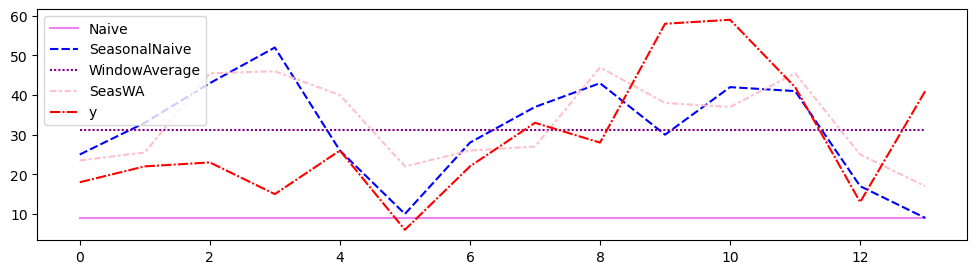

In [67]:
plt.figure(figsize=(12, 3))
g = sns.lineplot(data=p[['Naive', 'SeasonalNaive', 'WindowAverage','SeasWA', 'y']].head(14), palette=['violet', 'blue', 'purple', 'pink', 'red'])

In [39]:
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA, HoltWinters

model = StatsForecast(models=[AutoARIMA(season_length=7),
                              HoltWinters(season_length=7, error_type='A')],
                      freq='D', n_jobs=-1)

In [41]:
wapes_arima = ts_cross_val(model, ['AutoARIMA', 'HoltWinters'], cv=3)

,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,y
0,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-05,23.456581,1.824981,45.088181,24.743071,2.431175,47.054966,18.0
1,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-06,35.487854,13.165104,57.810600,31.907341,9.571941,54.242741,22.0
2,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-07,40.056362,17.689480,62.423244,40.001896,17.642887,62.360909,23.0
3,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-08,44.134167,21.764425,66.503914,44.077789,21.695066,66.460510,15.0
4,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-09,40.307091,17.937160,62.677017,38.686298,16.279760,61.092834,26.0
5,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-10,22.145634,0.000000,44.515575,21.823557,0.000000,44.254009,6.0
6,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-11,21.481403,0.000000,43.851345,21.819616,0.000000,44.274075,22.0
7,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-12,26.636833,3.265203,50.008465,24.674458,2.195894,47.153019,33.0
8,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-13,36.298180,12.862996,59.733360,31.840105,9.337347,54.342861,28.0
9,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-07-14,40.262833,16.823530,63.702133,39.936008,17.408970,62.463051,58.0


AutoARIMA WAPE: 0.3892430153327112
HoltWinters WAPE: 0.3994071837744909


,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,y
0,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-21,22.831556,1.066399,44.596714,24.011536,1.507078,46.515991,25.0
1,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-22,34.067070,11.614312,56.519825,31.698116,9.169709,54.226524,33.0
2,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-23,45.942646,23.446476,68.438820,45.679779,23.127354,68.232208,43.0
3,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-24,41.912766,19.413811,64.411720,45.639008,23.062489,68.215523,52.0
4,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-25,46.472702,23.973572,68.971832,44.406677,21.806004,67.007355,26.0
5,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-26,31.119610,8.620466,53.618752,29.314487,6.689590,51.939384,10.0
6,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-27,26.717142,4.217998,49.216286,26.885696,4.236515,49.534878,28.0
7,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-28,23.266579,0.000000,46.817249,23.984303,1.310776,46.657829,37.0
8,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-29,34.177277,10.560716,57.793839,31.671492,8.973559,54.369423,43.0
9,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-30,45.970566,22.349783,69.591347,45.653751,22.931356,68.376144,30.0


AutoARIMA WAPE: 0.3774007561709657
HoltWinters WAPE: 0.3384994271552729


,unique_id,ds,AutoARIMA,AutoARIMA-lo-90,AutoARIMA-hi-90,HoltWinters,HoltWinters-lo-90,HoltWinters-hi-90,y
0,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-07,28.961794,7.063089,50.860497,25.958118,3.337416,48.578823,22.0
1,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-08,30.397141,7.730656,53.063622,28.224739,5.579211,50.870266,18.0
2,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-09,45.140495,22.420223,67.860771,44.656460,21.985855,67.327065,48.0
3,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-10,49.811062,27.086956,72.535164,51.454300,28.758375,74.150223,40.0
4,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-11,40.560863,17.836483,63.285244,39.339985,16.618498,62.061474,54.0
5,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-12,28.509802,5.785404,51.234203,26.089899,3.342612,48.837189,34.0
6,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-13,29.236151,6.511750,51.960552,27.647926,4.874609,50.421242,24.0
7,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-14,28.757757,5.021057,52.494461,25.830145,3.030572,48.629715,17.0
8,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-15,30.342638,6.535355,54.149921,28.099438,5.273388,50.925484,51.0
9,16a5cdae362b8d27a1d8f8c7b78b4330-1a0f36f6e9256...,2023-06-16,45.125938,21.313625,68.938248,44.533775,21.681034,67.386513,46.0


AutoARIMA WAPE: 0.40306523668880095
HoltWinters WAPE: 0.3393904111688817


In [42]:
for num, mod in enumerate(['AutoARIMA', 'HoltWinters']):
    model_scores = [score[num] for score in wapes_arima]
    print(f'{mod} mean WAPE = {np.mean(model_scores)}')

AutoARIMA mean WAPE = 0.38990300273082595
HoltWinters mean WAPE = 0.3590990073662152
